In [1]:
# Rodar na primeira execução do código
# Definição do dataset utilizado

# Instalando as dependências do Kaggle
! pip install -q kaggle

# Carregando o token de API do Kaggle
from google.colab import files
files.upload()

# Criando o diretório do kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Baixando os dados do Kaggle utilizando o "Comando de API" do dataset
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Criando o diretório onde as imagens ficarão
! mkdir mri_dataset

# Descompactando a base de dados no diretório
! unzip brain-tumor-mri-dataset.zip -d mri_dataset

# Baixar o dataset contendo as imagens substutivas de Gliomas
! kaggle datasets download -d rahimanshu/figshare-brain-tumor-classification
! mkdir glioma_dataset
! unzip figshare-brain-tumor-classification.zip -d glioma_dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: mri_dataset/Training/notumor/Tr-no_1120.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1121.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1122.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1123.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1124.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1125.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1126.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1127.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1128.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1129.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1130.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1131.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1132.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1133.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1134.jpg  
  inflating: mri_dataset/Training/notumor/Tr-no_1135.jpg

In [2]:
# Importação das dependências

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.metrics as skm 
import seaborn as sns

from tqdm import tqdm
import os
from sklearn.utils import shuffle, class_weight
import cv2

from random import randint

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%config Completer.use_jedi = False

import warnings
warnings.simplefilter("ignore")

In [3]:
# Fixando o Pseudo-random Generator do numpy e tensorflow 
# com o objetivo de melhorar a reprodutibilidade do código

np.random.RandomState(10)
tf.random.set_seed(10)

In [4]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

X_treino = []
Y_treino = []

X_teste = []
Y_teste = []

image_size = 128

# Load the 'glioma' images from the new dataset
glioma_folder_path = os.path.join('/content/glioma_dataset', 'glioma')

glioma_images = []
for j in tqdm(os.listdir(glioma_folder_path)):
    img = cv2.imread(os.path.join(glioma_folder_path,j))
    img = cv2.resize(img,(image_size, image_size))
    glioma_images.append(img)

glioma_labels = ['glioma'] * len(glioma_images)

# Manually split the data
glioma_images_train = glioma_images[:1126]
glioma_images_test = glioma_images[1126:1426]

glioma_labels_train = glioma_labels[:1126]
glioma_labels_test = glioma_labels[1126:1426]

X_treino.extend(glioma_images_train)
Y_treino.extend(glioma_labels_train)
X_teste.extend(glioma_images_test)
Y_teste.extend(glioma_labels_test)

# Load the other class images from the original dataset
for i in class_names:
    if i != 'glioma':  # we already have the new glioma images
        folderPath = os.path.join('/content/mri_dataset','Training',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_treino.append(img)
            Y_treino.append(i)

        folderPath = os.path.join('/content/mri_dataset','Testing',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_teste.append(img)
            Y_teste.append(i)

100%|██████████| 300/300 [00:00<00:00, 353.07it/s]


In [5]:
# Armazenando os conjuntos em NumPy Array para melhor manipulação
        
X_treino = np.array(X_treino)
Y_treino = np.array(Y_treino)

X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)

In [6]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_treino),
                                                 y = Y_treino)

weight = {i : class_weights[i] for i in range(4)}
    
print(weight)

{0: 1.2249111900532859, 1: 1.0300597460791636, 2: 0.8647335423197492, 3: 0.946636925188744}


In [7]:
# Transformando as labels/classes em dados categóricos

Y_treino = np.unique(Y_treino, return_inverse = True)[1]
Y_teste = np.unique(Y_teste, return_inverse = True)[1]

In [8]:
Y_treino_count = np.bincount(Y_treino)

total = np.sum([Y_treino_count], axis=1)[0]

print(
    'Examples:\n    Total: {}\n    Glioma: {} ({:.2f}% of total)\n    Meningioma: {} ({:.2f}% of total)\n    No Tumor: {} ({:.2f}% of total)\n    Pituitary: {} ({:.2f}% of total)'.format(
    total, 
    Y_treino_count[0], 100 * Y_treino_count[0] / total, 
    Y_treino_count[1], 100 * Y_treino_count[1] / total, 
    Y_treino_count[2], 100 * Y_treino_count[2] / total, 
    Y_treino_count[3], 100 * Y_treino_count[3] / total, ))

Examples:
    Total: 5517
    Glioma: 1126 (20.41% of total)
    Meningioma: 1339 (24.27% of total)
    No Tumor: 1595 (28.91% of total)
    Pituitary: 1457 (26.41% of total)


In [9]:
# Normalização das imagens

X_treino = X_treino/255.0
X_teste = X_teste/255.0

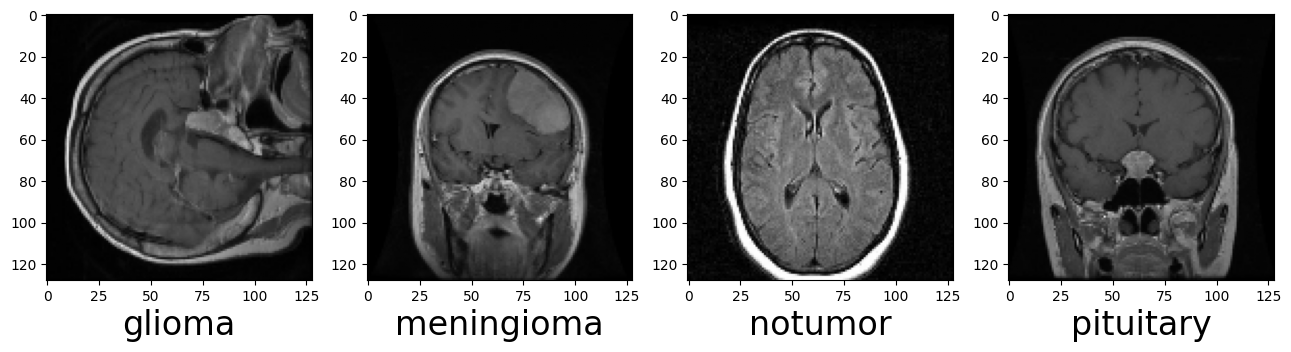

In [10]:
plt.figure(figsize=(20,20))
sum = 1017
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.imshow(X_treino[i + sum])
    plt.xlabel(class_names[Y_treino[i + sum]], fontsize=24)

    sum = sum + 1350
plt.show()

In [11]:
def get_model():

    #Definindo a arquitetura do modelo da CNN
    
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                    input_shape=(image_size,image_size,3), padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.20))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.30))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))             
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.40))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.60))

    model.add(Dense(4, activation='softmax'))

    # Configurando o otimizador do modelo, a função de cálculo de perda e
    # a métrica para visualização

    model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [12]:
#! pip install visualkeras

#import visualkeras
#from PIL import ImageFont

model = get_model()

#font = ImageFont.truetype("Roboto-Regular.ttf", 24)
#visualkeras.layered_view(model, legend=True, font=font)

#model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes = True, 
#           show_layer_names = False, show_layer_activations = True)

In [13]:
erlstp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=18)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights.hdf5',
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [14]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE, class_w):
    model = None
    model = get_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                validation_data = (val_x, val_y),
                class_weight=class_w,
                callbacks=[erlstp, reduce_lr, model_checkpoint], verbose=1)  
    
    print("\nValidation Score: ", model.evaluate(val_x, val_y))
    return results

In [15]:
n_folds=5
epochs=100
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ", i + 1)

    X_t, X_v, label_t, label_v = train_test_split(
      X_treino, Y_treino, test_size = 0.2, random_state = 13
    )

    X_t, label_t = shuffle(X_t, label_t, random_state = 13)
                                               
    model_history.append(fit_and_evaluate(X_t, X_v, label_t, label_v, epochs, batch_size, weight))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 1.2263 - accuracy: 0.3943
Epoch 1: val_accuracy improved from -inf to 0.67210, saving model to weights/weights.hdf5
138/138 [==============================] - 13s 15ms/step - loss: 1.2263 - accuracy: 0.3943 - val_loss: 1.0989 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 2/100
132/138 [===========================>..] - ETA: 0s - loss: 1.0481 - accuracy: 0.5161
Epoch 2: val_accuracy improved from 0.67210 to 0.70380, saving model to weights/weights.hdf5
138/138 [==============================] - 1s 9ms/step - loss: 1.0432 - accuracy: 0.5173 - val_loss: 0.8095 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 3/100
137/138 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.5652
Epoch 3: val_accuracy improved from 0.70380 to 0.89312, saving model to weights/weights.hdf5
138/138 [==============================] - 1s 9ms/step - loss: 0.9462 - accuracy: 0.5654 - val_loss: 0.7041 - val_accuracy

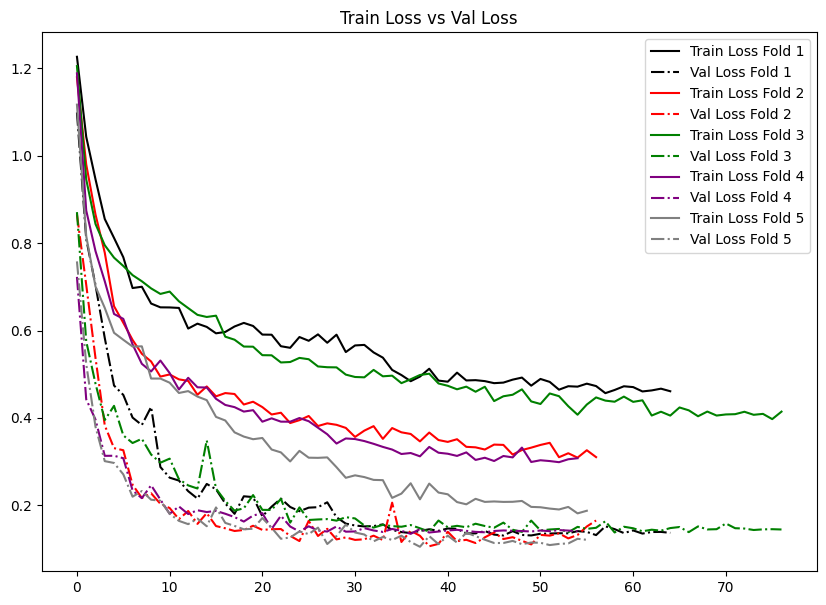

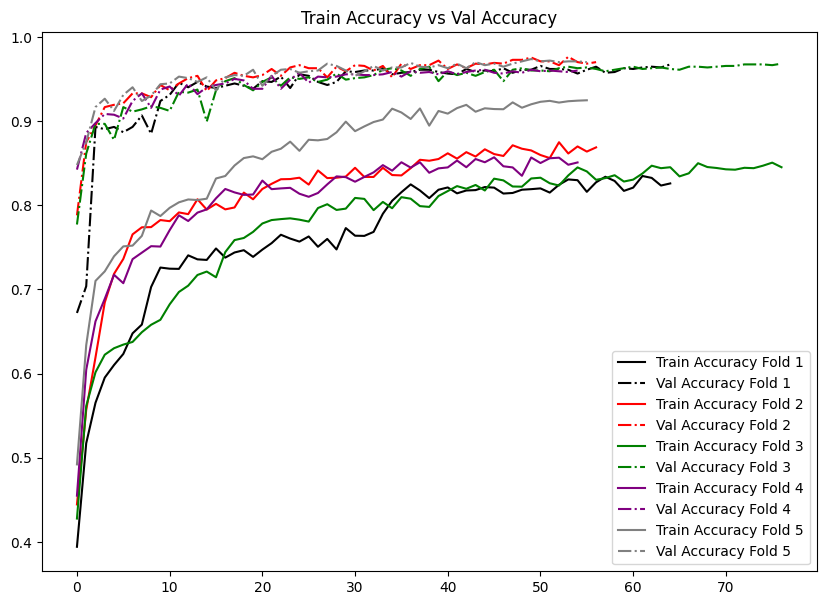

In [16]:
colors = ['black', 'red', 'green', 'purple', 'gray']
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Loss plot
plt.figure(figsize=(10,7))
plt.title('Train Loss vs Val Loss')
for i, color in enumerate(colors):
    plt.plot(model_history[i].history['loss'], label='Train Loss '+labels[i], color=color)
    plt.plot(model_history[i].history['val_loss'], label='Val Loss '+labels[i], color=color, linestyle = "dashdot")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,7))
plt.title('Train Accuracy vs Val Accuracy')
for i, color in enumerate(colors):
    plt.plot(model_history[i].history['accuracy'], label='Train Accuracy '+labels[i], color=color)
    plt.plot(model_history[i].history['val_accuracy'], label='Val Accuracy '+labels[i], color=color, linestyle = "dashdot")
plt.legend()
plt.show()


In [17]:

#Load the model that was saved by ModelCheckpoint
model = load_model('weights/weights.hdf5')

results = model.evaluate(X_teste, Y_teste)
print("Loss: {:0.4f}".format(results[0]))

41/41 [==============================] - 0s 5ms/step - loss: 0.1435 - accuracy: 0.9802
Loss: 0.1435


In [18]:
# Testando o modelo com o conjunto de teste, separado anteriormente

predicted_classes = model.predict(X_teste)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

print(classification_report(Y_teste, predicted_classes, target_names = class_names))

41/41 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.98      0.94      0.96       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



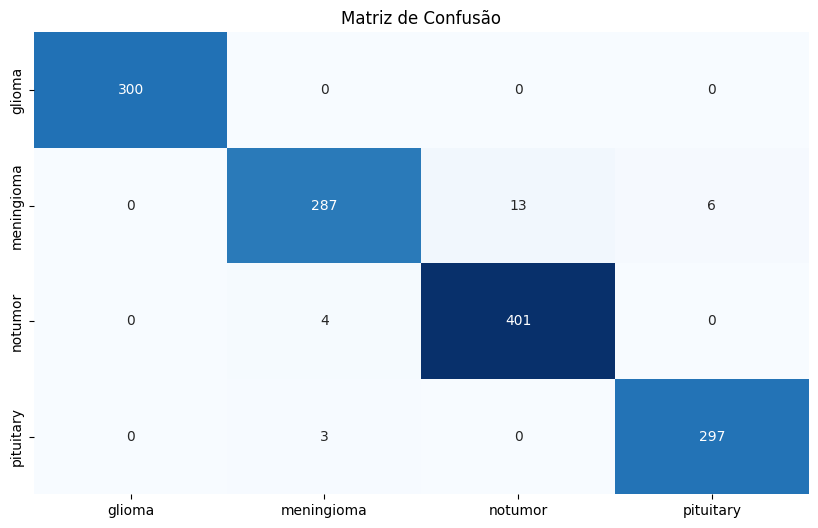

In [19]:
# Gerando e apresentando a matriz de confusão

cmat = confusion_matrix(Y_teste, predicted_classes)
cm_df = pd.DataFrame(cmat) 

cmat_df = pd.DataFrame(cmat,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(10,6))

sns.heatmap(cmat, annot = True, cmap = 'Blues', fmt = "d",
            cbar = False,
            xticklabels = class_names,
            yticklabels = class_names)

plt.title('Matriz de Confusão')
plt.show()

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations of the last conv layer.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

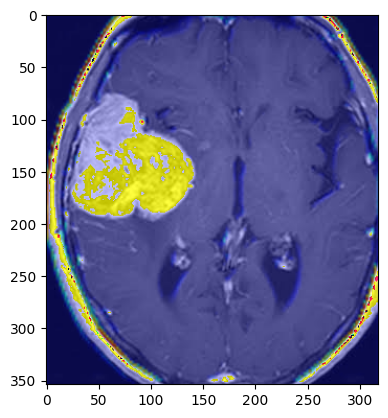

In [38]:
img = cv2.imread('/content/mri_dataset/Testing/meningioma/Te-me_0025.jpg')
#img = cv2.imread('/content/glioma_dataset/glioma/1130.jpg')
orig_img = img
img = cv2.resize(img, (image_size, image_size))

img = img.astype('float32') / 255.0  # Normalize pixel values

x = np.array(img)
x = np.expand_dims(x, axis=0)

layer_name = 'conv2d_6'

heatmap = make_gradcam_heatmap(x, model, layer_name)

# Load the original image
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Convert the grayscale heatmap to RGB
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap_colored, (orig_img.shape[1], orig_img.shape[0]))

# Superimpose the resized heatmap on the original image
superimposed_img = np.uint8(heatmap_resized * 0.5 + orig_img)

# Display the superimposed image
plt.imshow(superimposed_img)
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is"
    # with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

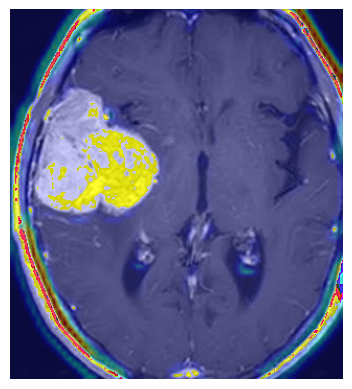

In [26]:
#img = cv2.imread('/content/mri_dataset/Testing/pituitary/Te-pi_0015.jpg')
img = cv2.imread('/content/mri_dataset/Testing/meningioma/Te-me_0025.jpg')
orig_img = img
img = cv2.resize(img, (image_size, image_size))

img = img.astype('float32') / 255.0  # Normalize pixel values

x = np.array(img)
x = np.expand_dims(x, axis=0)

last_conv_layer_name = 'conv2d_7'
classifier_layer_names = ['max_pooling2d_7', 'dropout_9', 'conv2d_8', 'max_pooling2d_8', 'dropout_10', 'flatten_2', 'dense_4', 'dropout_11', 'dense_5']
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name, classifier_layer_names)

# Then, you can overlay this heatmap on your original image
img = cv2.imread('/content/mri_dataset/Testing/meningioma/Te-me_0025.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Superimpose the heatmap on original image
superimposed_img = heatmap * 0.4 + img

# Display the image
plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')
plt.show()